# Required imports

In [1]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# Load results

In [5]:
methods = ['LBP', 'HOG', 'FN', 'CNN']
metrics   = ["FAR", "FRR", "Precision", "Recall", "Time"]
perturbations = [
    "original", "brightness_down", "brightness_up", "contrast_down", "contrast_up",
    "saturation_down", "saturation_up", "rotate_15", "rotate_-15", "gaussian_blur", "color_shift"
]

general_dfs = []
for m in methods:
    df = pd.read_csv(f"statistic_results/{m}_general_statistics.csv")
    df["Method"] = m
    general_dfs.append(df)
df_general_all = pd.concat(general_dfs)

perturbation_dfs = []
for m in methods:
    df = pd.read_csv(f"statistic_results/{m}_perturbation_statistics.csv")
    df["Method"] = m
    perturbation_dfs.append(df)
df_perturb_all = pd.concat(perturbation_dfs)

df_general_long = pd.melt(df_general_all, id_vars=["Method"], value_vars=metrics, var_name="Metric", value_name="Value")
df_perturb_long = pd.melt(df_perturb_all, id_vars=["Method", "perturbation"], value_vars=metrics[:4], var_name="Metric", value_name="Value")

# Statistical analysis

In [6]:
alpha = 0.05

In [28]:
def run_general_tests(df):
    results = []
    posthoc_all = {}
    for metric in metrics:
        data = df[df["Metric"] == metric]

        # normality
        pvals = [stats.shapiro(data[data["Method"] == m]["Value"]).pvalue for m in methods]
        normal = all(p > alpha for p in pvals)

        # homogeneity of variance
        grouped = [data[data["Method"] == m]["Value"] for m in methods]
        _, p_levene = stats.levene(*grouped)
        equal_var = p_levene > alpha

        if normal  and equal_var:
            stat, p = stats.f_oneway(*(data[data["Method"] == m]["Value"] for m in methods))
            test_type = "ANOVA"
            # post hoc Tukey
            tukey = pairwise_tukeyhsd(data["Value"], data["Method"])
            posthoc_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

        elif normal and not equal_var:
            model = ols("Value ~ Method", data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2, robust="hc3")
            stat = anova_table["F"][0]
            p = anova_table["PR(>F)"][0]
            test_type = "Welch ANOVA"
            # post hoc Games Howell
            posthoc_df = pg.pairwise_gameshowell(dv="Value", between="Method", data=data)

        else:
            stat, p = stats.kruskal(*(data[data["Method"] == m]["Value"] for m in methods))
            test_type = "Kruskal-Wallis"
            # post hoc Dunn
            posthoc_df = sp.posthoc_dunn(data, val_col="Value", group_col="Method", p_adjust="bonferroni")
            posthoc_df.reset_index(inplace=True)

        results.append({
            "Metric": metric,
            "Test": test_type,
            "Stat": stat,
            "p-value": p
        })

        posthoc_df.to_csv(f"statistic_results/posthoc_general_{metric}.csv", index=False)
        posthoc_all[metric] = posthoc_df

    pd.DataFrame(results).to_csv("statistic_results/general_test_results.csv", index=False)
    return results, posthoc_all

In [11]:
def run_perturb_tests(df):
    all_results = []
    posthoc_all = {}
    for method in methods:
        for metric in metrics[:4]:  # without time
            data = df[(df["Method"] == method) & (df["Metric"] == metric)]
            perturb_groups = [data[data["perturbation"] == p]["Value"] for p in perturbations]

            # normality
            pvals = [stats.shapiro(g).pvalue for g in perturb_groups if len(g) > 2]
            normal = all(p > alpha for p in pvals) if len(pvals) > 0 else False

            # variation
            p_levene = stats.levene(*perturb_groups).pvalue
            equal_var = p_levene > alpha

            if normal and equal_var:
                stat, p = stats.f_oneway(*perturb_groups)
                test_type = "ANOVA"
                # post-hoc Tukey
                tukey = pairwise_tukeyhsd(data["Value"], data["perturbation"])
                posthoc_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
            elif normal and not equal_var:
                # Welch ANOVA
                model = pg.welch_anova(dv="Value", between="perturbation", data=data)
                stat = model["F"].values[0]
                p = model["p-unc"].values[0]
                test_type = "Welch ANOVA"
                posthoc_df = pg.pairwise_gameshowell(dv="Value", between="perturbation", data=data)
            else:
                # Kruskal-Wallis
                stat, p = stats.kruskal(*perturb_groups)
                test_type = "Kruskal-Wallis"
                posthoc_df = sp.posthoc_dunn(data, val_col="Value", group_col="perturbation", p_adjust="bonferroni")
                posthoc_df.reset_index(inplace=True)

            all_results.append({
                "Method": method,
                "Metric": metric,
                "Test": test_type,
                "Stat": stat,
                "p-value": p
            })

            posthoc_df.to_csv(f"statistic_results/posthoc_{method}_{metric}.csv", index=False)
            if method not in posthoc_all:
                posthoc_all[method] = {}
            posthoc_all[method][metric] = posthoc_df

    pd.DataFrame(all_results).to_csv("statistic_results/perturbation_vs_test_results.csv", index=False)

    return all_results, posthoc_all

# Results presentation

## Evaluation Metrics Summary

### General Metrics

In [8]:
for metric in metrics:
    df_metric = df_general_all[["Method", metric]].copy()
    df_metric = df_metric.rename(columns={metric: "Value"})

    summary = df_metric.groupby("Method")["Value"].agg(
        mean="mean",
        std="std",
        min="min",
        q1=lambda x: x.quantile(0.25),
        median="median",
        q3=lambda x: x.quantile(0.75),
        max="max"
    ).round(4).reset_index()

    print(f"\n Metric: {metric}")
    print(summary.to_string(index=False))


 Metric: FAR
Method   mean    std    min     q1  median     q3    max
   CNN 0.4579 0.0167 0.4216 0.4491  0.4625 0.4694 0.4756
    FN 0.0965 0.0201 0.0654 0.0857  0.0979 0.1148 0.1209
   HOG 0.3999 0.0308 0.3648 0.3782  0.3850 0.4189 0.4608
   LBP 0.4778 0.0408 0.4118 0.4514  0.4862 0.5106 0.5261

 Metric: FRR
Method   mean    std    min     q1  median     q3    max
   CNN 0.4226 0.0276 0.3738 0.3991  0.4355 0.4424 0.4534
    FN 0.0927 0.0140 0.0652 0.0908  0.0949 0.1027 0.1059
   HOG 0.3576 0.0245 0.3146 0.3432  0.3602 0.3691 0.3956
   LBP 0.4226 0.0370 0.3696 0.3898  0.4277 0.4503 0.4798

 Metric: Precision
Method   mean    std    min     q1  median     q3    max
   CNN 0.5693 0.0097 0.5559 0.5629  0.5694 0.5759 0.5860
    FN 0.9082 0.0179 0.8875 0.8915  0.9075 0.9187 0.9361
   HOG 0.6279 0.0167 0.6006 0.6191  0.6322 0.6381 0.6548
   LBP 0.5593 0.0208 0.5279 0.5465  0.5601 0.5693 0.5953

 Metric: Recall
Method   mean    std    min     q1  median     q3    max
   CNN 0.5774 0.0276 0.

### Metrics for perturbations

In [9]:
for metric in metrics[:4]:
    for pert in perturbations:
        df_subset = df_perturb_all[df_perturb_all["perturbation"] == pert]
        df_metric = df_subset[["Method", metric]].copy()
        df_metric = df_metric.rename(columns={metric: "Value"})

        summary = df_metric.groupby("Method")["Value"].agg(
            mean="mean",
            std="std",
            min="min",
            q1=lambda x: x.quantile(0.25),
            median="median",
            q3=lambda x: x.quantile(0.75),
            max="max"
        ).round(4).reset_index()

        print(f"\n Perturbation: {pert} | Metric: {metric}")
        print(summary.to_string(index=False))


 Perturbation: original | Metric: FAR
Method   mean    std    min     q1  median     q3    max
   CNN 0.4579 0.0167 0.4216 0.4491  0.4625 0.4694 0.4756
    FN 0.0965 0.0201 0.0654 0.0857  0.0978 0.1148 0.1209
   HOG 0.3999 0.0308 0.3648 0.3782  0.3850 0.4189 0.4608
   LBP 0.4778 0.0408 0.4118 0.4514  0.4862 0.5106 0.5261

 Perturbation: brightness_down | Metric: FAR
Method   mean    std    min     q1  median     q3    max
   CNN 0.4292 0.0390 0.3627 0.3986  0.4421 0.4544 0.4756
    FN 0.1076 0.0200 0.0784 0.0912  0.1076 0.1165 0.1433
   HOG 0.4814 0.0546 0.4281 0.4401  0.4609 0.5184 0.5850
   LBP 0.4716 0.0564 0.3909 0.4334  0.4894 0.4984 0.5765

 Perturbation: brightness_up | Metric: FAR
Method   mean    std    min     q1  median     q3    max
   CNN 0.4596 0.0449 0.3987 0.4336  0.4576 0.4812 0.5440
    FN 0.1243 0.0255 0.0782 0.1151  0.1207 0.1426 0.1596
   HOG 0.4058 0.0381 0.3627 0.3869  0.3964 0.4031 0.4935
   LBP 0.2886 0.0694 0.1928 0.2229  0.3050 0.3331 0.4007

 Perturbation: 

In [26]:
tables = {}

for method in methods:
    for metric in metrics[:4]:
        df_sub = (
            df_perturb_all[df_perturb_all["Method"] == method]
            .loc[:, ["perturbation", metric]]
            .rename(columns={metric: "Value"})
        )
        summary = (
            df_sub.groupby("perturbation")["Value"].agg(
                mean="mean",
                std="std",
                min="min",
                q1=lambda x: x.quantile(0.25),
                median="median",
                q3=lambda x: x.quantile(0.75),
                max="max"
            )
            .round(4)
            .reset_index()
        )
        tables[(method, metric)] = summary

        print(f"\nMethod: {method} | Metric: {metric}")
        print(summary.to_string(index=False))


Method: LBP | Metric: FAR
   perturbation   mean    std    min     q1  median     q3    max
brightness_down 0.4716 0.0564 0.3909 0.4334  0.4894 0.4984 0.5765
  brightness_up 0.2886 0.0694 0.1928 0.2229  0.3050 0.3331 0.4007
    color_shift 0.4677 0.0527 0.3954 0.4251  0.4592 0.5016 0.5523
  contrast_down 0.4967 0.0617 0.3922 0.4841  0.5032 0.5205 0.5863
    contrast_up 0.3128 0.1082 0.2059 0.2386  0.2659 0.3570 0.5196
  gaussian_blur 0.6742 0.1248 0.3941 0.6384  0.6704 0.7598 0.8469
       original 0.4778 0.0408 0.4118 0.4514  0.4862 0.5106 0.5261
     rotate_-15 0.0585 0.1286 0.0000 0.0000  0.0098 0.0464 0.4183
      rotate_15 0.0588 0.1234 0.0000 0.0000  0.0098 0.0529 0.4020
saturation_down 0.4886 0.0442 0.4248 0.4580  0.4723 0.5306 0.5523
  saturation_up 0.4556 0.0430 0.3889 0.4245  0.4593 0.4784 0.5179

Method: LBP | Metric: FRR
   perturbation   mean    std    min     q1  median     q3    max
brightness_down 0.4819 0.0791 0.3489 0.4459  0.4837 0.5159 0.6056
  brightness_up 0.6695

In [10]:
for metric in metrics[:4]:
    df_m = df_perturb_all[["perturbation", "Method", metric]].copy()

    grouped = (
        df_m
        .groupby(["perturbation", "Method"])[metric]
        .agg(['mean', 'std'])
        .unstack("Method")
        .loc[perturbations]
        .round(4)
    )

    grouped.columns = [f"{method}_{stat}" for stat, method in grouped.columns]

    table = grouped.reset_index()
    table.to_csv(f"statistic_results/summary_{metric}.csv", index=False)

    print(f"\n=====  {metric}  =====")
    print(table.to_string(index=False))



=====  FAR  =====
   perturbation  CNN_mean  FN_mean  HOG_mean  LBP_mean  CNN_std  FN_std  HOG_std  LBP_std
       original    0.4579   0.0965    0.3999    0.4778   0.0167  0.0201   0.0308   0.0408
brightness_down    0.4292   0.1076    0.4814    0.4716   0.0390  0.0200   0.0546   0.0564
  brightness_up    0.4596   0.1243    0.4058    0.2886   0.0449  0.0255   0.0381   0.0694
  contrast_down    0.4514   0.1148    0.4733    0.4967   0.0169  0.0201   0.0502   0.0617
    contrast_up    0.4380   0.0949    0.3757    0.3128   0.0327  0.0223   0.0313   0.1082
saturation_down    0.5121   0.0923    0.4054    0.4886   0.0181  0.0232   0.0357   0.0442
  saturation_up    0.3884   0.0988    0.3956    0.4556   0.0349  0.0203   0.0316   0.0430
      rotate_15    0.0297   0.1203    0.2744    0.0588   0.0293  0.0218   0.1326   0.1234
     rotate_-15    0.0339   0.1233    0.0985    0.0585   0.0316  0.0294   0.0467   0.1286
  gaussian_blur    0.5032   0.1171    0.4550    0.6742   0.0352  0.0271   0.0642 

## Statistical analysis (results)

In [32]:
res, posthocs = run_general_tests(df_general_long)

df_res = pd.DataFrame(res)
df_res['Stat'] = df_res['Stat'].apply(lambda x: f"{x:.4f}")
df_res['p-value'] = df_res['p-value'].apply(lambda x: f"{x:.2e}")

print(10*"-", "  RESULTS GENERAL ", 10*"-")
print(df_res.to_string(index=False))
print(10*"-", " POST-HOC RESULTS ", 10*"-")
for metric, df_posthoc in posthocs.items():
    print(f"\nPost-hoc results for metric: {metric}")
    print(df_posthoc)

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\260604003.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = anova_table["F"][0]
C:\Users\marts\AppData\Local\Temp\ipykernel_21480\260604003.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = anova_table["PR(>F)"][0]


----------   RESULTS GENERAL  ----------
   Metric           Test     Stat  p-value
      FAR    Welch ANOVA 635.5842 3.21e-31
      FRR Kruskal-Wallis  30.9654 8.64e-07
Precision          ANOVA 959.5553 2.17e-34
   Recall Kruskal-Wallis  30.9654 8.64e-07
     Time Kruskal-Wallis  36.5854 5.63e-08
----------  POST-HOC RESULTS  ----------

Post-hoc results for metric: FAR
     A    B   mean(A)   mean(B)      diff        se          T         df  \
0  CNN   FN  0.457923  0.096535  0.361388  0.008260  43.752037  17.422316   
1  CNN  HOG  0.457923  0.399882  0.058041  0.011088   5.234739  13.865240   
2  CNN  LBP  0.457923  0.477813 -0.019890  0.013938  -1.427018  11.936144   
3   FN  HOG  0.096535  0.399882 -0.303347  0.011634 -26.073171  15.472347   
4   FN  LBP  0.096535  0.477813 -0.381278  0.014377 -26.520232  13.120768   
5  HOG  LBP  0.399882  0.477813 -0.077931  0.016168  -4.820075  16.752485   

           pval     hedges  
0  0.000000e+00  18.739752  
1  6.660620e-04   2.242129  

In [15]:
short_names = {
    "brightness_down": "br_dn",
    "brightness_up": "br_up",
    "color_shift": "clr_sh",
    "contrast_down": "ctr_dn",
    "contrast_up": "ctr_up",
    "gaussian_blur": "gauss",
    "original": "orig",
    "rotate_-15": "rot_m15",
    "rotate_15": "rot_p15",
    "saturation_down": "sat_dn",
    "saturation_up": "sat_up"
}

In [18]:
res_per, posthocs_per = run_perturb_tests(df_perturb_long)

df_res_per = pd.DataFrame(res_per)
df_res_per['Stat'] = df_res_per['Stat'].apply(lambda x: f"{x:.2f}")
df_res_per['p-value'] = df_res_per['p-value'].apply(lambda x: f"{x:.2e}")

print(10*"-", " RESULTS PERTURBATION ", 10*"-")
print(df_res_per.to_string(index=False))
print(10*"-", "   POST-HOC RESULTS   ", 10*"-")
for perturb in posthocs_per:
    print(f"\n{'='*30}")
    print(f"POST-HOC TESTS for perturbation: {perturb}")
    print(f"{'='*30}")
    for metric in posthocs_per[perturb]:
        print(f"\n--- Metric: {metric} ---")
        df_ph = posthocs_per[perturb][metric].copy()
        for col in df_ph.select_dtypes(include=['float', 'double']).columns:
            df_ph[col] = df_ph[col].apply(lambda x: f"{x:.2f}")
        print(df_ph.to_string(index=False))

----------  RESULTS PERTURBATION  ----------
Method    Metric           Test   Stat  p-value
   LBP       FAR Kruskal-Wallis  78.21 1.13e-12
   LBP       FRR Kruskal-Wallis  81.08 3.08e-13
   LBP Precision Kruskal-Wallis  17.47 6.46e-02
   LBP    Recall Kruskal-Wallis  81.08 3.08e-13
   HOG       FAR Kruskal-Wallis  68.30 9.45e-11
   HOG       FRR    Welch ANOVA 104.80 3.18e-25
   HOG Precision    Welch ANOVA  10.36 2.71e-08
   HOG    Recall    Welch ANOVA 104.80 3.18e-25
    FN       FAR Kruskal-Wallis  20.99 2.12e-02
    FN       FRR Kruskal-Wallis  34.53 1.50e-04
    FN Precision Kruskal-Wallis  23.34 9.56e-03
    FN    Recall Kruskal-Wallis  34.53 1.50e-04
   CNN       FAR Kruskal-Wallis  82.25 1.81e-13
   CNN       FRR Kruskal-Wallis  70.65 3.32e-11
   CNN Precision Kruskal-Wallis  28.35 1.58e-03
   CNN    Recall Kruskal-Wallis  70.65 3.32e-11
----------    POST-HOC RESULTS    ----------

POST-HOC TESTS for perturbation: LBP

--- Metric: FAR ---
          index brightness_down bri

## Visualization of Results

### Histograms

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\9798280.py:4: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
C:\Users\marts\AppData\Local\Temp\ipykernel_21480\9798280.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


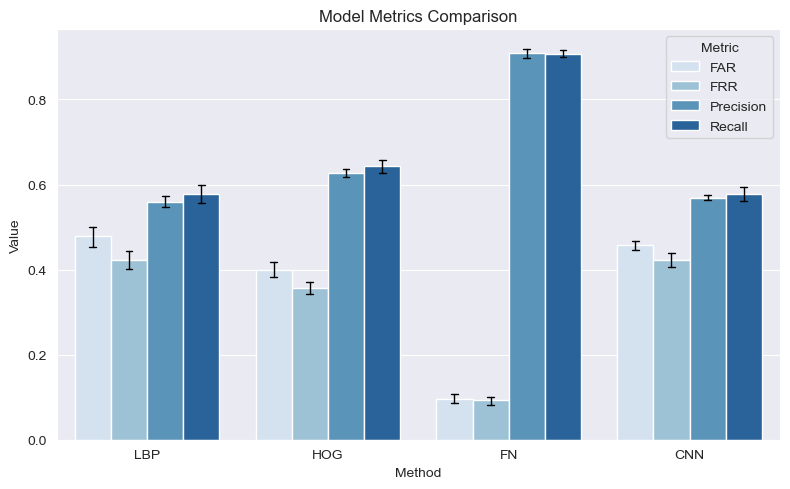

In [21]:
class_metrics = ["FAR", "FRR", "Precision", "Recall"]

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_general_long[df_general_long["Metric"].isin(class_metrics)],
    x="Method",
    y="Value",
    hue="Metric",
    palette="Blues",
    capsize=.15,
    errcolor="black",
    errwidth=1,
)

plt.title("Model Metrics Comparison")
plt.ylabel("Value")
plt.tight_layout()
plt.savefig("plots/bar_metrics.svg", format="svg")
plt.show()

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4148432263.py:2: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(
C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4148432263.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


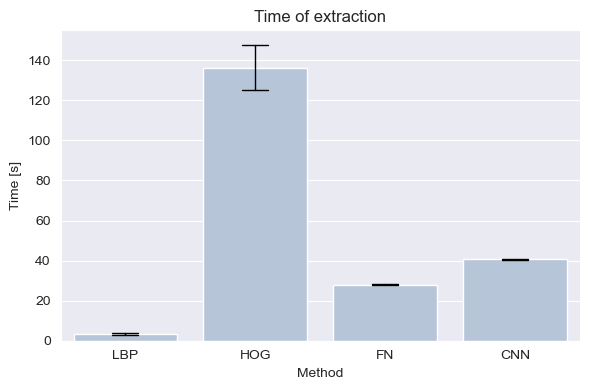

In [22]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_general_long[df_general_long["Metric"] == "Time"],
    x="Method", y="Value",
    color="lightsteelblue", capsize=.2, errcolor="black", errwidth=1
)
plt.title("Time of extraction")
plt.ylabel("Time [s]")
plt.tight_layout()
plt.savefig("plots/time.svg", format="svg")
plt.show()

### Box-plots

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4271067642.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Figure size 1000x600 with 0 Axes>

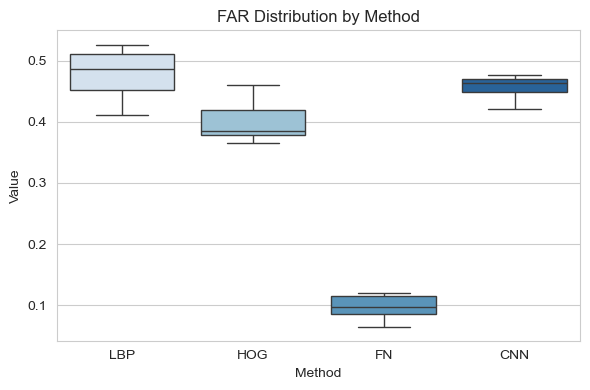

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4271067642.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


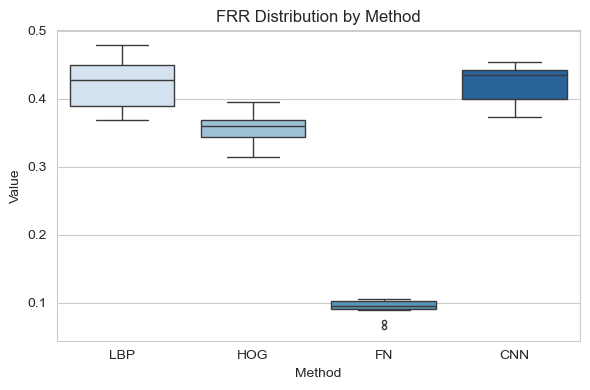

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4271067642.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


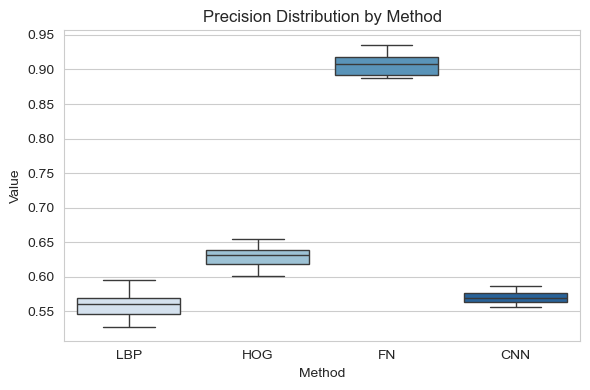

C:\Users\marts\AppData\Local\Temp\ipykernel_21480\4271067642.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


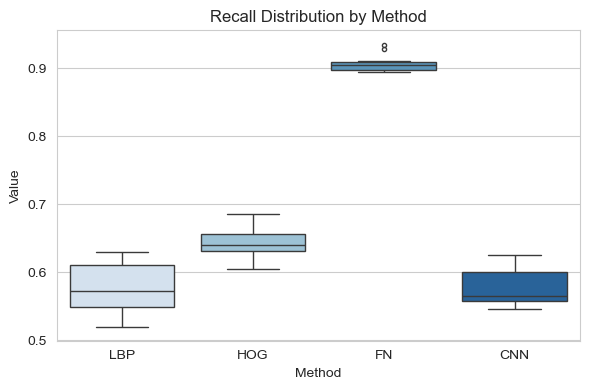

In [23]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

for metric in class_metrics:
    plt.figure(figsize=(6, 4))

    data_metric = df_general_long[df_general_long["Metric"] == metric]

    sns.boxplot(
        data=data_metric,
        x="Method",
        y="Value",
        palette="Blues",
        fliersize=3,
        linewidth=1
    )

    plt.title(f"{metric} Distribution by Method")
    plt.ylabel("Value")
    plt.xlabel("Method")
    plt.tight_layout()

    filename = f"plots/boxplot_{metric.lower()}.svg"
    plt.savefig(filename, format="svg")
    plt.show()

### Heatmaps

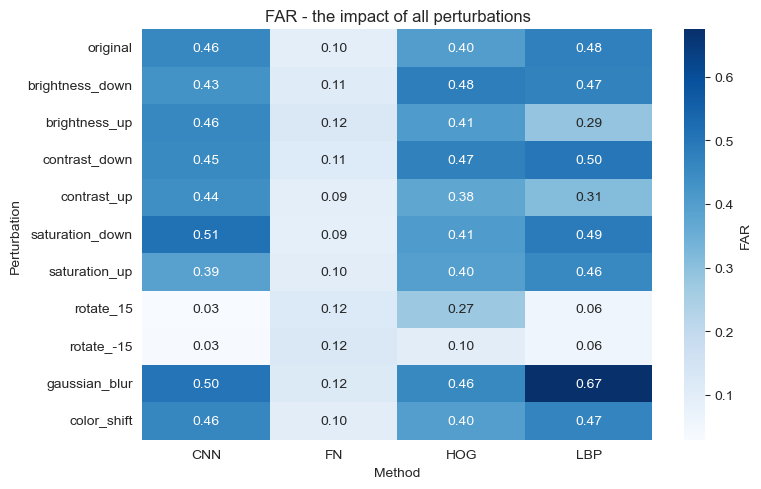

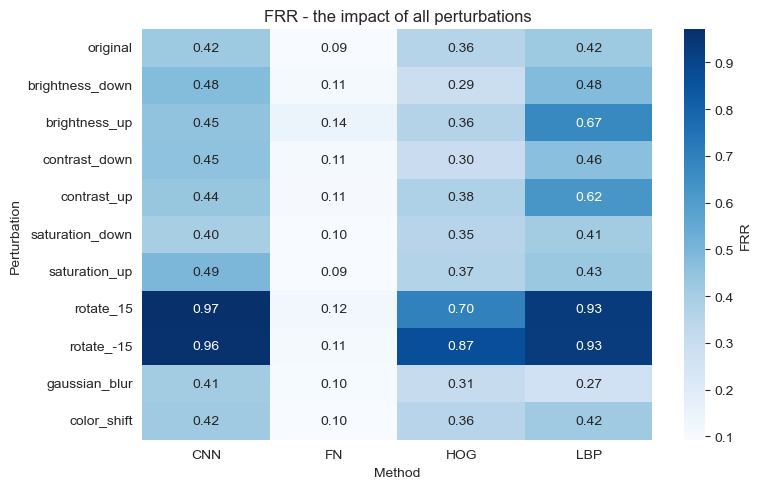

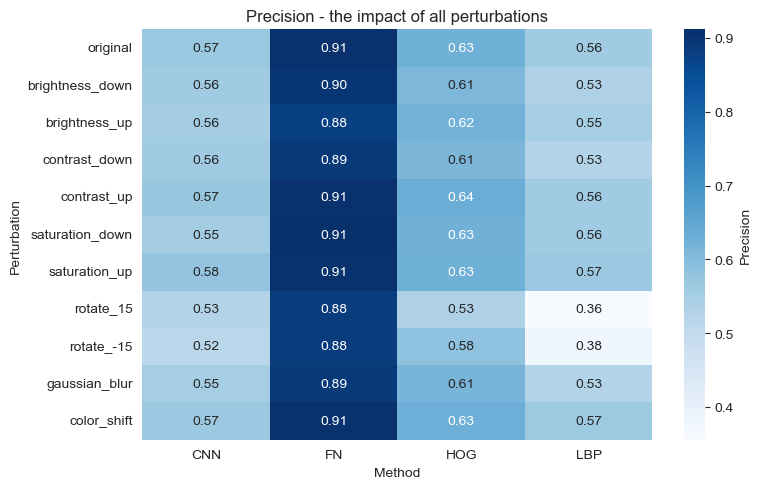

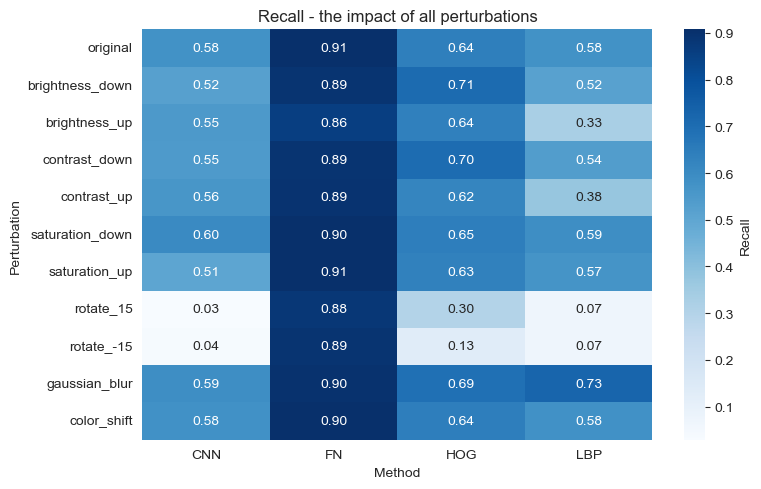

In [24]:
for metric in metrics[:4]:
    pivot = (
        df_perturb_long[df_perturb_long["Metric"].str.lower() == metric.lower()]
        .pivot_table(index="perturbation", columns="Method", values="Value", aggfunc="mean")
        .reindex(index=perturbations)
    )
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues",
                cbar_kws={"label": metric})
    plt.title(f"{metric} - the impact of all perturbations")
    plt.xlabel("Method")
    plt.ylabel("Perturbation")
    plt.tight_layout()
    plt.savefig(f"plots/heatmap_perturbations_{metric}.svg", format="svg")
    plt.show()